In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Loading

In [3]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [4]:
train_dir

'/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'

The preprocess_input function preprocesses a tensor or Numpy array encoding a batch of images. It's based on all the preprocessing functions needed by DenseNet model.
This this we don't need to care about the rescaling function (eg. by dividing the tensor's values by 255.)

In [5]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  rotation_range=20,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [6]:
train_ds = image_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


It's visible that all the value are scaled. 

In [7]:
for x,y in train_ds:
    print(x[0])
    print(y[0])
    break

[[[0.6666667  0.5058824  0.41960788]
  [0.64705884 0.48627454 0.40000004]
  [0.64705884 0.48627454 0.40000004]
  ...
  [0.38823533 0.3647059  0.30980393]
  [0.36862746 0.3529412  0.30588236]
  [0.2784314  0.2627451  0.21568629]]

 [[0.6666667  0.5019608  0.4156863 ]
  [0.6431373  0.48235297 0.39607847]
  [0.64705884 0.48627454 0.40000004]
  ...
  [0.39607847 0.37254903 0.31764707]
  [0.37647063 0.3529412  0.30588236]
  [0.3254902  0.30980393 0.2627451 ]]

 [[0.6784314  0.5019608  0.41960788]
  [0.654902   0.4901961  0.4039216 ]
  [0.654902   0.4901961  0.4039216 ]
  ...
  [0.4156863  0.38823533 0.3254902 ]
  [0.36862746 0.3372549  0.28627452]
  [0.32941177 0.30588236 0.2509804 ]]

 ...

 [[0.9921569  0.9921569  0.9921569 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9843138  0.9843138  0.9843138 ]
  ...
  [0.9686275  0.9607844  0.9725491 ]
  [0.9686275  0.9607844  0.9725491 ]
  [0.96470594 0.9568628  0.9686275 ]]

 [[0.9803922  0.9803922  0.9725491 ]
  [0.9803922  0.9803922  0.9725491 ]


Let's print the input shape:
- 32 is the batch size
- 256s are the pixel's values.
- 3 are the channel (rgb)

In [8]:
for x,y in train_ds:
    print(x.shape)
    print(y.shape)
    break

(64, 256, 256, 3)
(64,)


In [9]:
train_ds.class_indices

{'fake': 0, 'real': 1}

# Data Visualization

The problem is visualizing the images with the scaled values. These will not be perfectly visible. Next version will fix the visualization section. For the moment we can go further.

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for i in range(9):
    img, label = train_ds.next()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    plt.title("Label: ", list(train_ds.class_indices)[label[0].astype("uint8")])
    plt.axis("off")

We can now define the pre-trained model and the custom top layers.

# CNN model architecture (DenseNet121)

In [10]:
densenet_ft = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_shape=(256,256,3))

model_ft = tf.keras.models.Sequential([ 
        densenet_ft, #model architecture
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

29084464/29084464 [==============================] - 0s 0us/step


In [11]:
model_ft.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Training

In [12]:
history_ft = model_ft.fit(train_ds, epochs = 10 , validation_data = valid_ds)

Epoch 1/10
1563/1563 [==============================] - 1050s 612ms/step - loss: 0.1253 - accuracy: 0.9493 - val_loss: 0.8324 - val_accuracy: 0.7425
Epoch 2/10
1563/1563 [==============================] - 756s 484ms/step - loss: 0.0407 - accuracy: 0.9852 - val_loss: 0.0363 - val_accuracy: 0.9868
Epoch 3/10
1563/1563 [==============================] - 756s 484ms/step - loss: 0.0321 - accuracy: 0.9879 - val_loss: 2.6683 - val_accuracy: 0.5666
Epoch 4/10
1563/1563 [==============================] - 758s 485ms/step - loss: 0.0258 - accuracy: 0.9906 - val_loss: 0.0691 - val_accuracy: 0.9730
Epoch 5/10
1563/1563 [==============================] - 756s 484ms/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.0389 - val_accuracy: 0.9865
Epoch 6/10
1563/1563 [==============================] - 757s 484ms/step - loss: 0.0197 - accuracy: 0.9932 - val_loss: 0.2806 - val_accuracy: 0.8992
Epoch 7/10
1563/1563 [==============================] - 759s 486ms/step - loss: 0.0168 - accuracy: 0.9940 - val

In [13]:
model_ft.save("./densenet_fine_tuned.h5")

# Results

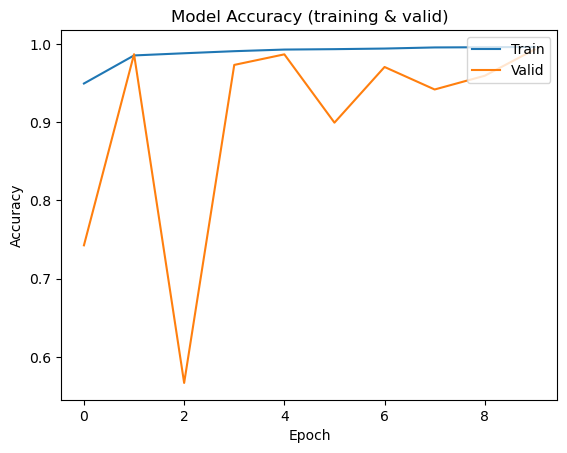

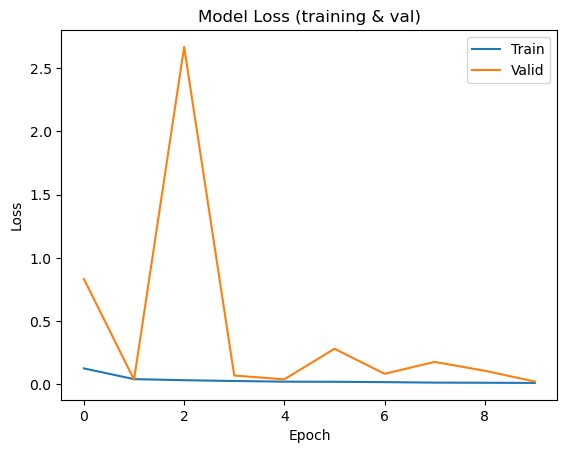

In [14]:
import matplotlib.pyplot as plt

plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [15]:
from keras.models import load_model
model = load_model('/kaggle/working/densenet_fine_tuned.h5')

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 172s 550ms/step - loss: 0.0224 - accuracy: 0.9926
Test Loss: 0.022434012964367867
Test Accuracy: 0.9926000237464905


# Image example - Qualitative results

1/1 [==============================] - 0s 32ms/step
REAL [[1.]]


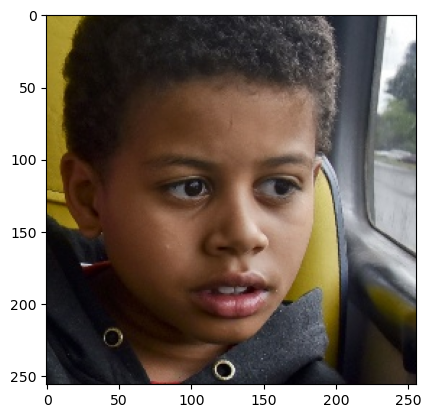

In [70]:
import numpy as np
from keras.preprocessing import image

#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00343.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

if(result.round() == 1):
    print("REAL", result)
else:
    print("FAKE", result)
        

The result score is near 1 if the image is **real** and 0 if the image is **fake**. 

1/1 [==============================] - 0s 37ms/step
FAKE [[2.782574e-15]]


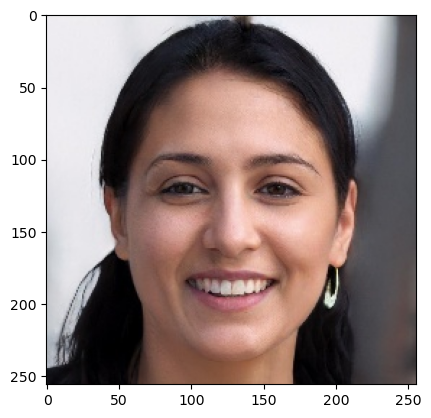

In [157]:
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00XUQJZGHU.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)

#fake example
test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

if(result.round() == 1):
    print("REAL", result)
else:
    print("FAKE", result)
        

# Quantitative results

In this case train_ds prediction and train_ds.classes **are not alligned**. I need to re-define test_ds with shuffle disabled.

In [123]:
test_ds = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.).flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False)

Found 20000 images belonging to 2 classes.


In [152]:
import numpy as np

import sklearn

# Assuming you have defined your model as 'model'
predicted_labels = model_ft.predict(test_ds)

313/313 [==============================] - 82s 261ms/step


In [153]:
true_labels = test_ds.classes

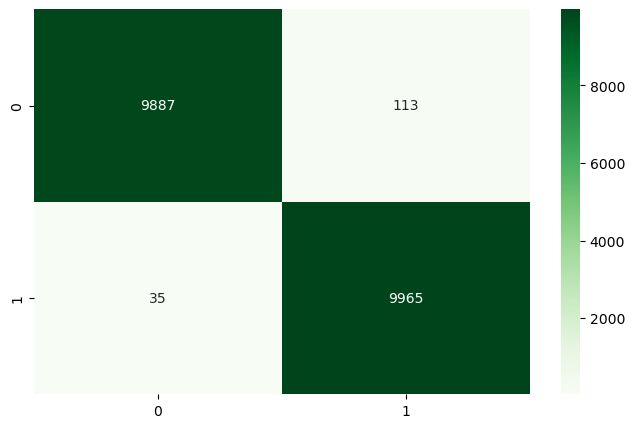

In [154]:
import seaborn as sns
from sklearn import metrics

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [155]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.9926

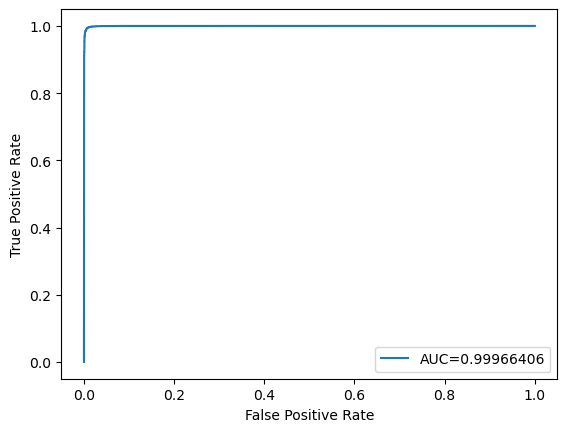

In [156]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# END :)

We can try to augment the training data. We can also try to use tf.keras.utils.image_dataset_from_directory for data processing for better performance. Let's do these steps in the next version. 

In [158]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.1, seed=42),
    tf.keras.layers.RandomContrast(factor=0.3, seed=42),
    #tf.keras.layers.Rescaling(1./255)
])